In [16]:
import sys
sys.path.append('../training_performance')

import platform
from pathlib import Path
from datetime import datetime, timedelta
import datajoint as dj
dj.blob.use_32bit_dims = True # necessary for pd.blob read

from create_trials_df import create_trials_df_from_dj
from create_days_df import create_days_df_from_dj, lazy_load_days_summary_df

from multiplot_summaries import *

import plot_utils as pu
import dj_utils as dju
import dir_utils as du

from plot_trials_info import *
from plot_days_info import *

import seaborn as sns
import pandas as pd
from matplotlib import pyplot as plt
import numpy as np 

# settings
%load_ext autoreload
%autoreload 2
sns.set_context("talk")

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [126]:
# animals1 = [
#     "R010",
#     "R011",
#     "R012",
#     "R013",
#     "R014",
#     "R015",
#     "R512",
#     "R513",
#     "R621",
#     "R622",
#     "R623",
#     "R624",
# ]

# date_min, date_max = dju.return_date_window(latest_date=None, n_days_back=None)
# trials_df1 = create_trials_df_from_dj(
#     animal_ids=animals1, date_min=date_min, date_max=date_max
# )

# animals2 = [
#     "C214",
#     "C215",
#     "C220",
#     "C221",
#     "C222",
#     "C223",
# ]

# trials_df2 = create_trials_df_from_dj(
#     animal_ids=animals2, date_min="2023-08-18", date_max=date_max
# )

# n_animals = len(animals1) + len(animals2)

# trials_df = pd.concat([trials_df1, trials_df2], ignore_index=True)

# trials_df.to_csv("2023_10_11_thesis_committee_trials", index=False)

trials_df = pd.read_csv("2023_10_11_thesis_committee_trials")

/var/folders/__/8jn6qz211155h1xb451s5zcr0000gn/T/ipykernel_95308/1926097377.py:40: DtypeWarning: Columns (54) have mixed types. Specify dtype option on import or set low_memory=False.
  trials_df = pd.read_csv("2023_10_11_thesis_committee_trials")


In [127]:
def determine_species(animal_id):
    first_char = animal_id[0]
    if first_char == "C":
        return "rat"
    elif first_char == "R":
        second_char = int(animal_id[1])
        if second_char < 5:
            return "rat"
        else:
            return "mouse"
    else:
        return "unknown"


trials_df["species"] = trials_df["animal_id"].apply(determine_species)

SPECIES_COLOR_MAP = {
    "rat": "royalblue",
    "mouse": "palevioletred",
    "unknown": "black",
}


def get_species_color(species):
    return SPECIES_COLOR_MAP[species]

trials_df["date"] = pd.to_datetime(trials_df["date"], format="%Y-%m-%d")
trials_df["start_date"] = trials_df.groupby("animal_id")["date"].transform(
    lambda x: (x - x.min()).dt.days
)

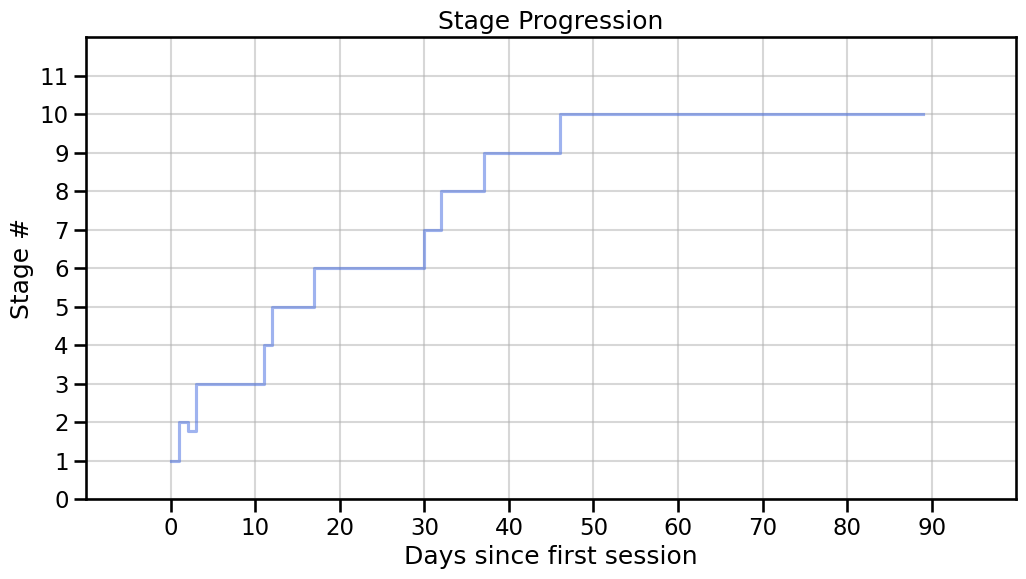

In [138]:
fig, ax = plt.subplots(figsize=(12, 6))
plot_stage(
    trials_df.query("animal_id == 'R014'"),
    ax=ax,
    group="start_date",
    aesthetics=False,
    color=SPECIES_COLOR_MAP["rat"],
    alpha=0.5,
    label=None,
)

max_stage = 11
ax.grid(alpha=0.5)
_ = ax.set(
    ylabel="Stage #",
    title="Stage Progression",
    ylim=(0, max_stage + 1),
    yticks=range(max_stage + 1),
    xlabel="Days since first session",
    xlim=(-10, 100),
    xticks=np.arange(stop=100, step=10),
)

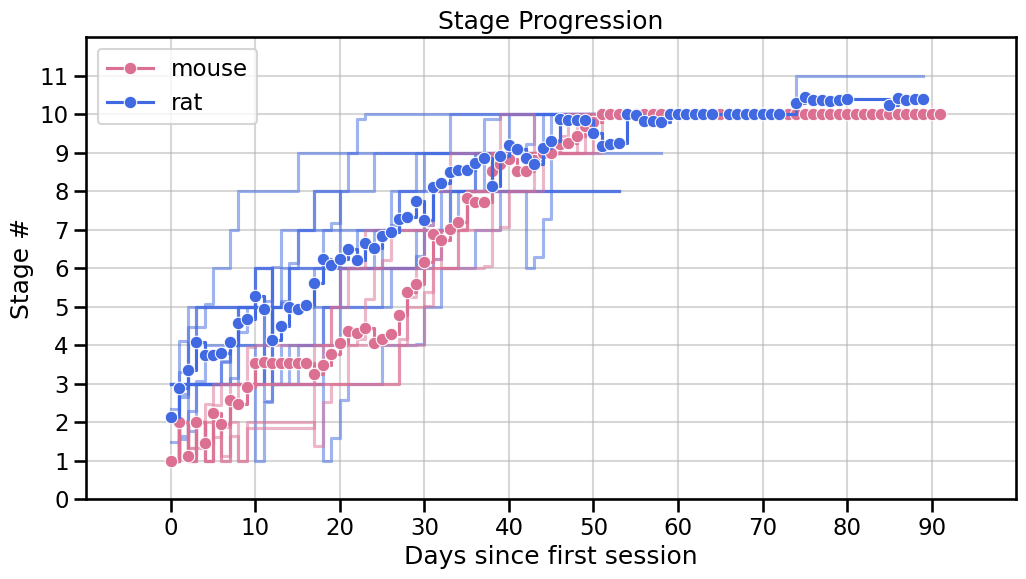

In [139]:
fig, ax = plt.subplots(figsize=(12, 6))
for animal_id, sub_df in trials_df.groupby("animal_id"):
    plot_stage(
        sub_df,
        ax=ax,
        group="start_date",
        aesthetics=False,
        color=get_species_color(sub_df.species.iloc[0]),
        alpha=0.5,
        label=None,
    )


for species, sub_df in trials_df.groupby("species"):
    plot_stage(
        sub_df,
        ax=ax,
        group="start_date",
        aesthetics=False,
        color=get_species_color(species),
        marker="o",
        label=species,
    )

max_stage = int(trials_df.stage.max())
ax.grid(alpha=0.5)
_ = ax.set(
    ylabel="Stage #",
    title="Stage Progression",
    ylim=(0, max_stage + 1),
    yticks=range(max_stage + 1),
    xlabel="Days since first session",
    xlim=(-10, 100),
    xticks=np.arange(stop=100, step=10),
)

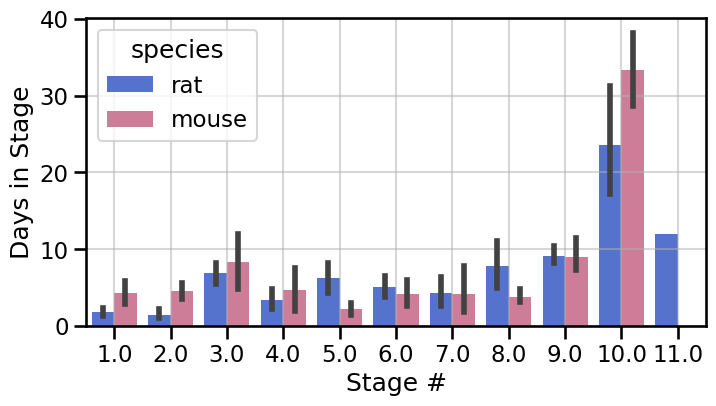

In [140]:
unique_days_by_animal_stage = (
    trials_df.groupby(["animal_id", "stage", "species"])
    .agg(unique_days=pd.NamedAgg(column="date", aggfunc="nunique"))
    .reset_index()
)

fig, ax = plt.subplots(figsize=(8, 4))
sns.barplot(
    data=unique_days_by_animal_stage,
    x="stage",
    y="unique_days",
    hue="species",
    palette=SPECIES_COLOR_MAP,
    ax=ax,
)

ax.set(
    xlabel="Stage #",
    ylabel="Days in Stage",
)

ax.grid(alpha=0.5)

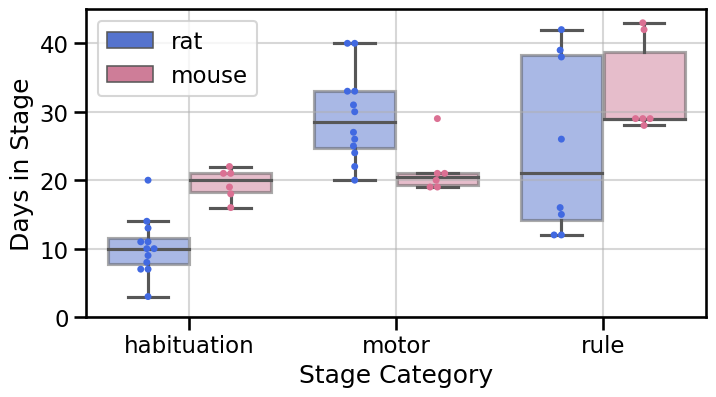

In [141]:
def determine_stage_category(stage):
    if stage <= 4:
        return "habituation"
    elif stage <= 9:
        return "motor"
    else:
        return "rule"


trials_df["stage_category"] = trials_df.stage.apply(determine_stage_category)

unique_days_by_animal_stage = (
    trials_df.groupby(["animal_id", "stage_category", "species"])
    .agg(unique_days=pd.NamedAgg(column="date", aggfunc="nunique"))
    .reset_index()
)

fig, ax = plt.subplots(figsize=(8, 4))
sns.swarmplot(
    data=unique_days_by_animal_stage,
    x="stage_category",
    y="unique_days",
    hue="species",
    palette=SPECIES_COLOR_MAP,
    ax=ax,
    dodge=True,
    label="",
)

sns.boxplot(
    data=unique_days_by_animal_stage,
    x="stage_category",
    y="unique_days",
    hue="species",
    palette=SPECIES_COLOR_MAP,
    ax=ax,
    showfliers=False,
    boxprops=dict(alpha=0.5),
)

ax.set(xlabel="Stage Category", ylabel="Days in Stage", ylim=(0, None))

ax.grid(alpha=0.5)

# turn off legend for swarmplot
handles, labels = ax.get_legend_handles_labels()
ax.legend(handles[2:], labels[2:])

In [147]:
days_to_rule_learning

species animal_id  start_date
0    mouse      R512          46
1    mouse      R513          46
2    mouse      R621          48
3    mouse      R622          39
4    mouse      R623          49
5    mouse      R624          50
6      rat      C215          37
7      rat      C221          22
8      rat      C222          33
9      rat      R011          40
10     rat      R012          44
11     rat      R013          45
12     rat      R014          46
13     rat      R015          42

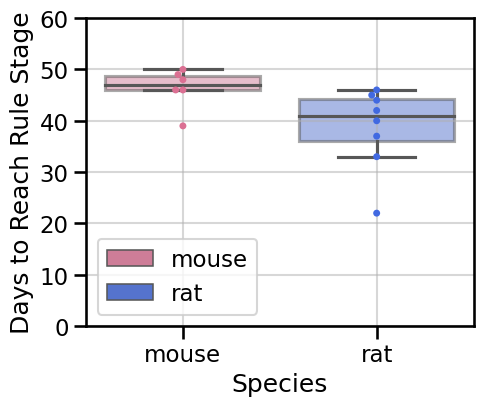

In [166]:
stage_10_df = trials_df.query("stage >= 10").copy()

days_to_rule_learning = (
    stage_10_df.groupby(["species", "animal_id"]).start_date.min().reset_index()
)

fig, ax = plt.subplots(figsize=(5, 4))
sns.swarmplot(
    data=days_to_rule_learning,
    x="species",
    y="start_date",
    hue="species",
    palette=SPECIES_COLOR_MAP,
    ax=ax,
    dodge=False,
)

sns.boxplot(
    data=days_to_rule_learning,
    x="species",
    y="start_date",
    hue="species",
    palette=SPECIES_COLOR_MAP,
    ax=ax,
    showfliers=False,
    boxprops=dict(alpha=0.5),
    dodge=False,
)
#
ax.set(xlabel="Species", ylabel="Days to Reach Rule Stage", ylim=(0, 60))

ax.grid(alpha=0.5)

# turn off legend for swarmplot
handles, labels = ax.get_legend_handles_labels()
ax.legend(handles[2:], labels[2:])

In [206]:
days_to_rule_learning

species animal_id  start_date
0    mouse      R512          46
1    mouse      R513          46
2    mouse      R621          48
3    mouse      R622          39
4    mouse      R623          49
5    mouse      R624          50
6      rat      C215          37
7      rat      C221          22
8      rat      C222          33
9      rat      R011          40
10     rat      R012          44
11     rat      R013          45
12     rat      R014          46
13     rat      R015          42

In [ ]:
# sort dataframe by species


'R512'

In [188]:
animals_in_stage_10 = stage_10_df.animal_id.unique()

stage_9_df = trials_df.query("stage >= 9 and animal_id in @animals_in_stage_10").copy()

In [224]:
# Find the minimum start_date for each animal_id in stage 10
min_start_date_10 = (
    stage_9_df.query("stage == 10").groupby("animal_id")["start_date"].min()
)

# Create a new column in stage_9_df that contains the minimum start_date of stage 10 for each animal
# This will map the minimum start_date from stage 10 to all rows of the corresponding animal_id
stage_9_df["start_date_10"] = stage_9_df["animal_id"].map(min_start_date_10)

# Now normalize the start_date by subtracting start_date_10 from it
stage_9_df["normalized_start_date"] = (
    stage_9_df["start_date"] - stage_9_df["start_date_10"]
)

stage_9_df = stage_9_df.query("normalized_start_date >= -4").copy()

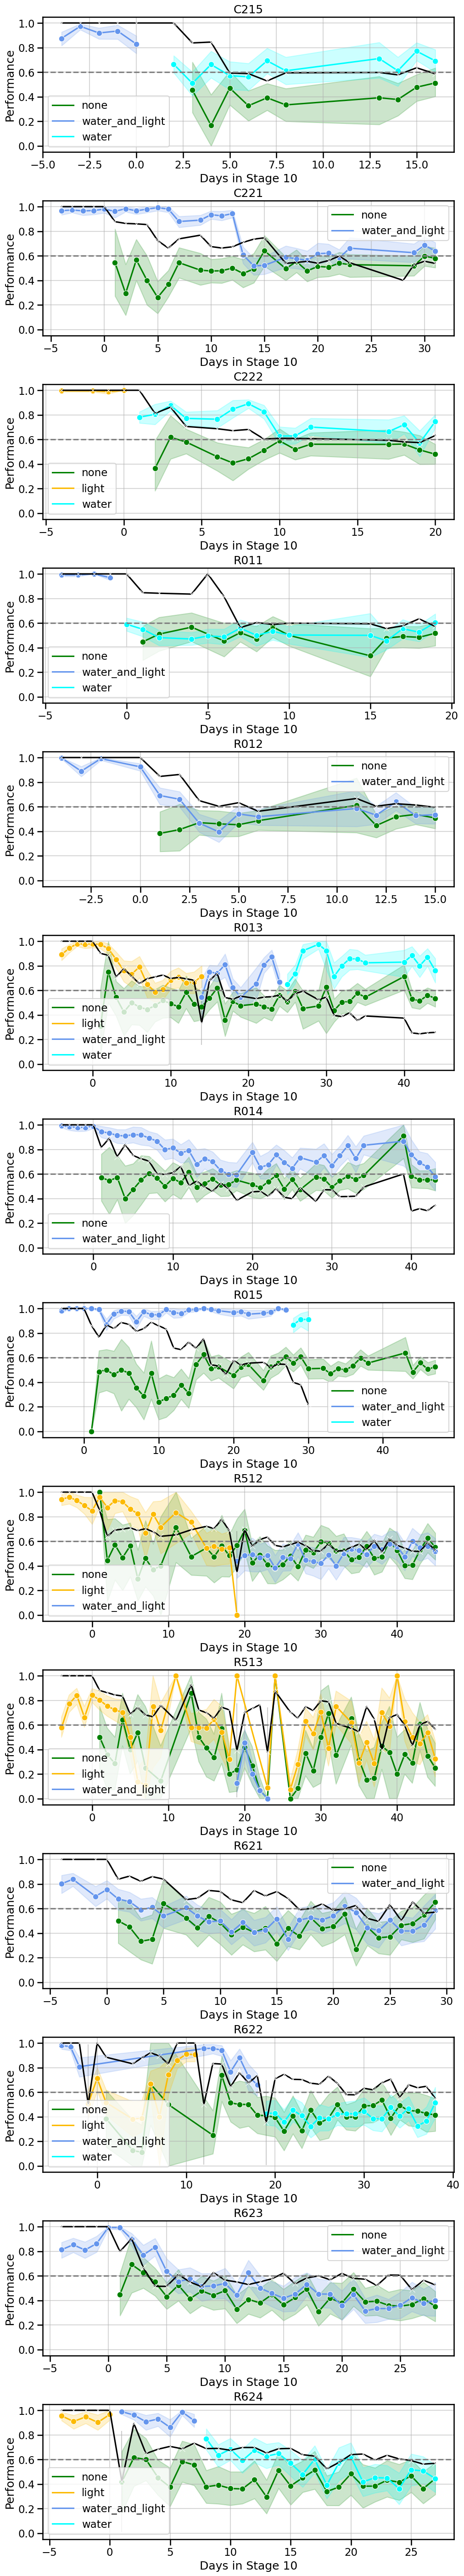

In [225]:
fig, ax = plt.subplots(
    n_animals, 1, figsize=(10, 4 * n_animals), sharey=True, constrained_layout=True
)
for ii, (animal_id, sub_df) in enumerate(stage_9_df.groupby("animal_id")):
    plot_performance_by_give(
        sub_df, ax[ii], group="normalized_start_date", title=animal_id, aesthetics=False
    )

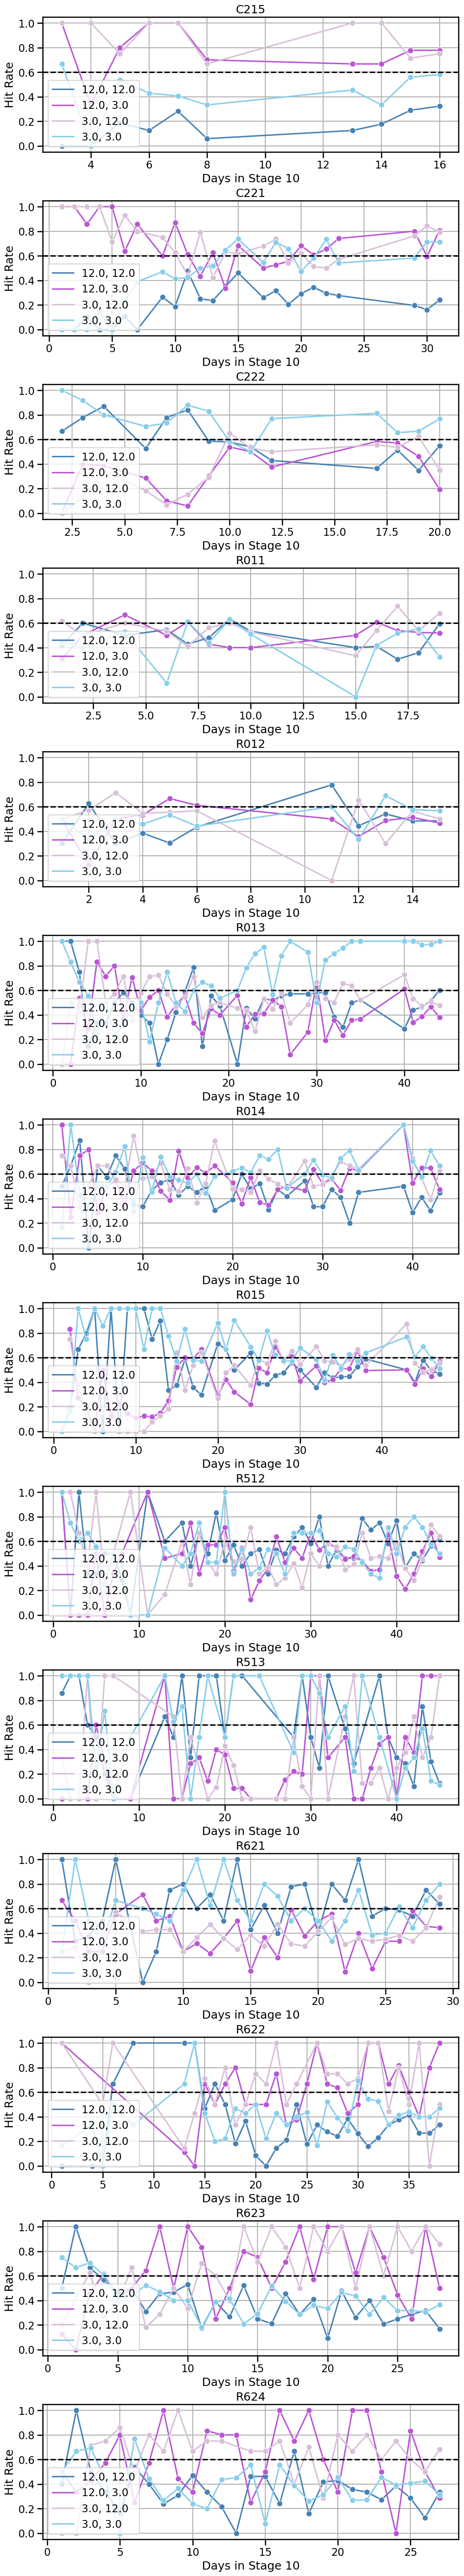

In [229]:
fig, ax = plt.subplots(
    n_animals, 1, figsize=(10, 4 * n_animals), sharey=True, constrained_layout=True
)
for ii, (animal_id, sub_df) in enumerate(stage_9_df.groupby("animal_id")):
    plot_non_give_stim_performance(
        sub_df,
        ax[ii],
        group="normalized_start_date",
        title=animal_id,
        xaxis_label=False,
    )

In [137]:
## gnp plots if time